In [1]:
import muon as mu
import mofapy2
import mofax
import pandas as pd
import scanpy as sc
import numpy as np

## Load data

First we will load the evodevo data containing normalized gene expression data for 5 species (groups) and 5 organs (views) as well as the developmental time information for each sample.

In [3]:
datadir = "data/evodevo"

In [4]:
data = pd.read_csv(f"{datadir}/evodevo.csv", sep=",", index_col=0)
data

/icgc/dkfzlsdf/analysis/B260/software/users/velten/envs/muon/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


group    view             sample                 feature      value  \
1        Human   Brain        10wpc_Human   ENSG00000000457_Brain   8.573918   
2        Human   Brain        10wpc_Human   ENSG00000001084_Brain   8.875957   
3        Human   Brain        10wpc_Human   ENSG00000001167_Brain  11.265237   
4        Human   Brain        10wpc_Human   ENSG00000001461_Brain   7.374965   
5        Human   Brain        10wpc_Human   ENSG00000001561_Brain   7.311018   
...        ...     ...                ...                     ...        ...   
3193836  Human  Testis  youngMidAge_Human  ENSG00000271503_Testis   1.178014   
3193837  Human  Testis  youngMidAge_Human  ENSG00000271601_Testis   1.178014   
3193838  Human  Testis  youngMidAge_Human  ENSG00000272442_Testis   4.476201   
3193839  Human  Testis  youngMidAge_Human  ENSG00000272886_Testis   1.178014   
3193840  Human  Testis  youngMidAge_Human  ENSG00000273079_Testis   8.311393   

         time  
1           7  
2           7  
3           7  
4           7  
5           7  
...       ...  
3193836    21  
3193837    21  
3193838    21  
3193839    21  
3193840    21  

[3193840 rows x 6 columns]

First, we create a collection of AnnData objects from this dataframe, one for each organ.

In [5]:
tt = data[data.view == 'Brain'].pivot(index=['group','sample'], columns='feature', values='value')

In [6]:
tt.set_index(tt.index.droplevel(level=0))

feature      ENSG00000000457_Brain  ENSG00000001084_Brain  \
sample                                                      
10wpc_Human               8.573918               8.875957   
11wpc_Human               8.439675               8.737682   
12wpc_Human               8.399178               8.916387   
13wpc_Human               8.637347               8.831740   
16wpc_Human               8.525125               8.575862   
...                            ...                    ...   
e16_Rat                   8.376069              10.116910   
e17_Rat                   8.565662              10.135640   
e18_Rat                   8.535613              10.161520   
e19_Rat                   8.647557              10.210530   
e20_Rat                   8.580514              10.170800   

feature      ENSG00000001167_Brain  ENSG00000001461_Brain  \
sample                                                      
10wpc_Human              11.265237               7.374965   
11wpc_Human              10.855314               8.066544   
12wpc_Human              12.555510               9.253555   
13wpc_Human              10.916489               9.190959   
16wpc_Human              11.271736               8.177629   
...                            ...                    ...   
e16_Rat                   9.817295               7.547978   
e17_Rat                   9.855783               7.091983   
e18_Rat                  10.002510               6.962930   
e19_Rat                   9.929732               7.405138   
e20_Rat                   9.856243               7.821672   

feature      ENSG00000001561_Brain  ENSG00000001617_Brain  \
sample                                                      
10wpc_Human               7.311018               9.959839   
11wpc_Human               7.354726              10.431113   
12wpc_Human               8.763702               9.946536   
13wpc_Human               8.158240              10.279600   
16wpc_Human               7.857303              10.363036   
...                            ...                    ...   
e16_Rat                   7.494774               9.942880   
e17_Rat                   7.324568               9.908100   
e18_Rat                   7.826152               9.984483   
e19_Rat                   7.690958              10.302840   
e20_Rat                   7.871427              10.429220   

feature      ENSG00000001629_Brain  ENSG00000001631_Brain  \
sample                                                      
10wpc_Human              10.542619               9.692082   
11wpc_Human              10.308780               9.242115   
12wpc_Human              11.530929              10.033949   
13wpc_Human              11.287268               9.510370   
16wpc_Human              11.402954               9.523244   
...                            ...                    ...   
e16_Rat                  10.754940              10.235290   
e17_Rat                  10.863260              10.382240   
e18_Rat                  11.153140              10.280180   
e19_Rat                  11.215820              10.394190   
e20_Rat                  11.198730              10.291220   

feature      ENSG00000002549_Brain  ENSG00000002745_Brain  ...  \
sample                                                     ...   
10wpc_Human               9.180280               4.281878  ...   
11wpc_Human               9.350255               3.363064  ...   
12wpc_Human               9.278142               4.322361  ...   
13wpc_Human               9.033614               4.784136  ...   
16wpc_Human               8.833177               2.785827  ...   
...                            ...                    ...  ...   
e16_Rat                   9.615162               4.295448  ...   
e17_Rat                   9.686985               3.694717  ...   
e18_Rat                   9.614488               5.023464  ...   
e19_Rat                   9.598997               5.439916  ...   
e20_Rat                   9.5356

In [7]:
# Note: resorting by groups here before setting sample as index
# muon interface to mofa does not maintain the right samples_names and samples_groups 
# correspondences if groups are not listed sequentially in the samples of the AnnData objects

views = (data['view']).unique()
data_list = [data[data.view == m].pivot(index=['group','sample'], columns='feature', values='value') for m in views]
data_list = [dd.set_index(dd.index.droplevel(level=0)) for dd in data_list]
mods = {views[m]:sc.AnnData(data_list[m]) for m in range(len(views))}
mods

{'Brain': AnnData object with n_obs × n_vars = 83 × 7696,
 'Cerebellum': AnnData object with n_obs × n_vars = 83 × 7696,
 'Heart': AnnData object with n_obs × n_vars = 83 × 7696,
 'Liver': AnnData object with n_obs × n_vars = 83 × 7696,
 'Testis': AnnData object with n_obs × n_vars = 83 × 7696}

In addition, we keep the meta data for each sample, containing the developmental time points.

In [8]:
obs = data[['sample', 'time', 'group']].drop_duplicates()
obs.rename(columns = {'group' : 'species'}, inplace = True)
obs = obs.set_index('sample') 
obs

time species
sample                         
10wpc_Human           7   Human
11wpc_Human           8   Human
12wpc_Human           9   Human
13wpc_Human          10   Human
16wpc_Human          11   Human
...                 ...     ...
senior_Human         23   Human
teenager_Human       19   Human
toddler_Human        17   Human
youngAdult_Human     20   Human
youngMidAge_Human    21   Human

[83 rows x 2 columns]

We create a muon object

In [9]:
mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(obs)

This contains both the gene expression data,

In [10]:
mdata
mdata['Brain']

AnnData object with n_obs × n_vars = 83 × 7696

as well as the sample-level information given by the developmental time points, which are not yet matched for different species.

In [11]:
mdata.obs

time species
sample                   
10wpc_Human     7   Human
11wpc_Human     8   Human
12wpc_Human     9   Human
13wpc_Human    10   Human
16wpc_Human    11   Human
...           ...     ...
e16_Rat         6     Rat
e17_Rat         7     Rat
e18_Rat         8     Rat
e19_Rat         9     Rat
e20_Rat        10     Rat

[83 rows x 2 columns]

## Integrate data

MEFISTO can be run on a MuData using the mofa command and specifying the time information to use.

We will fill missing samples in certain modalities with NAs by using use_obs='union'.

We specify to use the species as groups.

As we want to incorporate the time information we specify which column in the metadata to use as covariate for mefisto ("time").

In addition, we tell the model that we want to learn an alignment of the time points from different species by setting mefisto_warping to True and using Mouse as reference.

For illustration, we only use a small number of training iterations.

In [12]:
ref_species = np.where(mdata.obs['species'].unique() == "Mouse")[0]
ref_species = ref_species.item()
ref_species

1

In [13]:
mu.tl.mofa(mdata, use_obs='union', 
           groups_label="species",
           n_factors=5, 
           mefisto_covariate = 'time',
           mefisto_warping = True,
           mefisto_warping_ref = ref_species,
           outfile="models/mefisto_evodevo.hdf5",
           n_iterations = 25)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='Brain' group='Human' with N=23 samples and D=7696 features...
Loaded view='Brain' group='Mouse' with N=14 samples and D=7696 features...
Loaded view='Brain' group='Opossum' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rabbit' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rat' with N=16 samples and D=7696 features...
Loade

## Visualization in the factor space

Let's take a look at the decomposition learnt by the model.

... storing 'species' as categorical


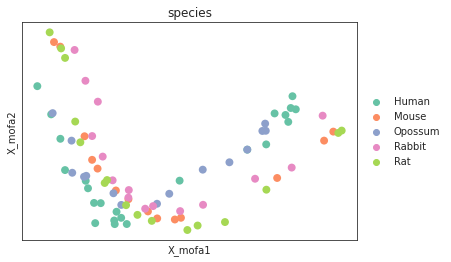

In [14]:
mu.pl.mofa(mdata, color="species", size = 250)

... storing 'species' as categorical


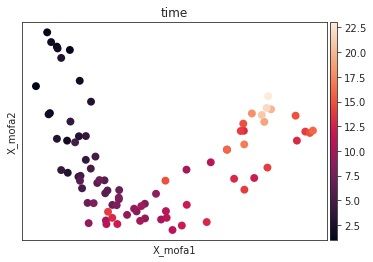

In [15]:
mu.pl.mofa(mdata, color="time", size = 250)

... storing 'species' as categorical


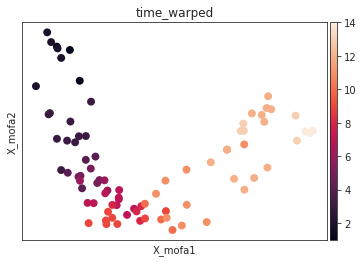

In [16]:
mu.pl.mofa(mdata, color="time_warped", size = 250)

## Latent factors versus common developmental time

We can plot the latent processes along the inferred common developmental time.

Before alignment:

<AxesSubplot:xlabel='time', ylabel='Factor1'>

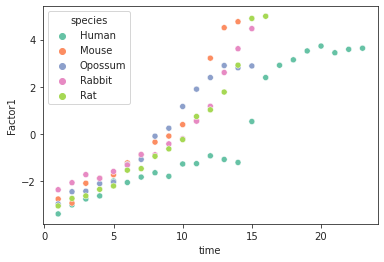

In [17]:
import seaborn as sns
df = pd.DataFrame({'time' : mdata.obs['time'], 'Factor1' : mdata.obsm['X_mofa'][:,0], 'species' : mdata.obs['species']})
sns.scatterplot(x = "time", y = "Factor1", hue = "species", data = df)

After alignment:

<AxesSubplot:xlabel='time', ylabel='Factor1'>

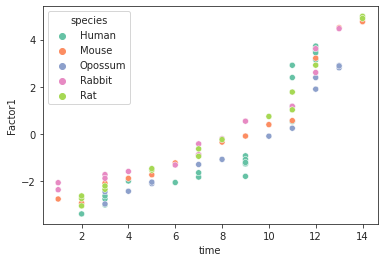

In [19]:
df = pd.DataFrame({'time' : mdata.obs['time_warped'], 'Factor1' : mdata.obsm['X_mofa'][:,0], 'species' : mdata.obs['species']})
sns.scatterplot(x = "time", y = "Factor1", hue = "species", data = df)

## Alignment

We can also take a look at the learnt alignemnt.

<AxesSubplot:xlabel='time', ylabel='time_warped'>

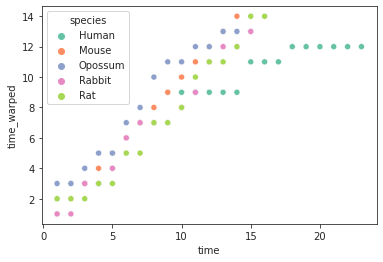

In [18]:
sns.scatterplot(x = "time", y = "time_warped", hue = "species", data = mdata.obs)

## Further analyes

Additionally we can take a look at the smoothness and sharedness of the factors, interpolate the factors or cluster the species based on the learnt group kernel of each latent factor.
This is not yet implemented for muon and can be done from R as described [here](https://raw.githack.com/bioFAM/MEFISTO_tutorials/master/evodevo_tutorial.html).